In [1]:
%pip install astroquery
from astroquery.utils.tap.core import TapPlus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
from astropy.table import Table, Column
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import corner
import astropy.units as u
from astropy.io import fits
import os
import requests
from bs4 import BeautifulSoup
from astropy.table import Table
from scipy.optimize import curve_fit
import arviz as az

Note: you may need to restart the kernel to use updated packages.


## Data Acquisition: Downloading APOGEE Spectra

In [2]:

# Fields and the base URL for the APOGEE spectra
fields = ["M15", "N6791", "K2_C4_168-21", "060+00"]
base_url = "https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/"

# Directory to store the downloaded files
download_dir = "apogee_spectra"
os.makedirs(download_dir, exist_ok=True)

# Iteration over the fields and download the spectra
for field in fields:
    field_url = base_url + field + "/"
    response = requests.get(field_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        file_names = [a['href'] for a in soup.find_all('a') if a['href'].startswith('apStar-r') and not a['href'].startswith('apStarLSF')]
        
        # Downloading each file
        for file_name in file_names:
            file_name = file_name.replace('%2B', '+')
            file_url = field_url + file_name
            file_path = os.path.join(download_dir, file_name)

            # Check if the file already exists
            if not os.path.exists(file_path):
                r = requests.get(file_url)
                
                if r.status_code == 200:
                    with open(file_path, 'wb') as f:
                        f.write(r.content)

In [32]:
save_dir = "apogee_spectra"

# Count of files in the directory
num_files = len([name for name in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, name))])

print(f"Number of files in '{save_dir}': {num_files}")

Number of files in 'apogee_spectra': 1875


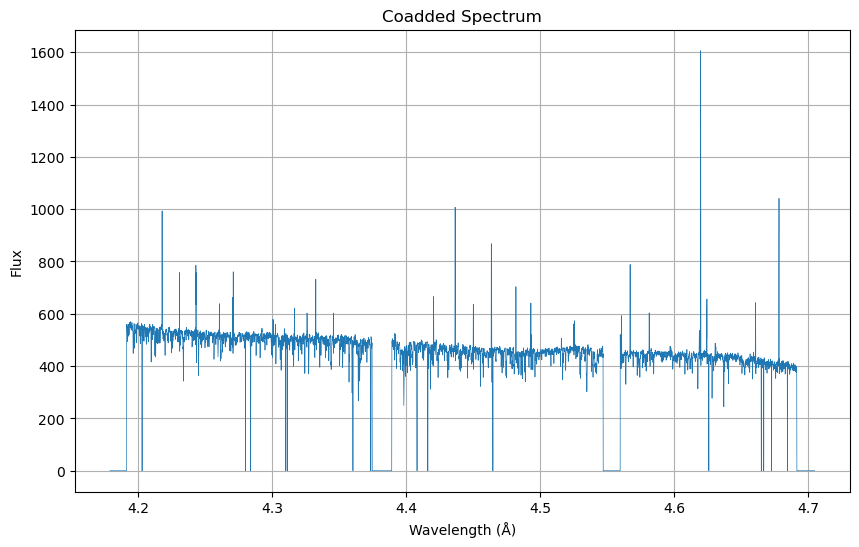

In [33]:
file_path = 'apogee_spectra/apStar-r12-2M03501997+2458304.fits'


with fits.open(file_path) as hdul:
    coadded_spectrum = hdul[1].data
    flux = coadded_spectrum[0]

    header = hdul[1].header
    start_wavelength = header['CRVAL1']  # Starting wavelength in Angstroms
    log_wavelength_step = header['CDELT1']  # Logarithmic wavelength step
    num_pixels = header['NAXIS1']  # Number of wavelength pixels
    wavelength = start_wavelength * 10**(log_wavelength_step * np.arange(num_pixels))
    
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, lw=0.5)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Coadded Spectrum')
    plt.grid(True)
    plt.show()

## Data Preparation: Extracting Stellar Labels from the allStar Catalog

In [35]:
# Load the allStar catalog
allstar = Table.read('allStar-r12-l33.fits', memmap=True)

In [36]:
# Directory containing the downloaded spectra
spectra_dir = 'apogee_spectra'

# List tof APOGEE IDs
apogee_ids = []

# Iterating over the files in the directory
for filename in os.listdir(spectra_dir):
    if filename.startswith('apStar-r') and filename.endswith('.fits'):
        apogee_id = filename.split('-')[-1].replace('.fits', '')
        apogee_ids.append(apogee_id)


matched_catalog = allstar[np.isin(allstar['APOGEE_ID'], apogee_ids)]

In [37]:
filtered_allstar = matched_catalog[(matched_catalog['SNR'] >= 50) &
                           (matched_catalog['LOGG'] < 4) &
                           (matched_catalog['TEFF'] < 5700) &
                           (matched_catalog['FE_H'] > -1) &
                           (~np.isnan(matched_catalog['TEFF'])) &
                           (~np.isnan(matched_catalog['LOGG'])) &
                           (~np.isnan(matched_catalog['FE_H'])) &
                           (~np.isnan(matched_catalog['MG_FE'])) &
                           (~np.isnan(matched_catalog['SI_FE']))]

# Saving the filtered catalog
filtered_allstar.write('filtered_allStar.fits', format='fits',overwrite=True)

In [36]:
filtered_allstar = Table.read('filtered_allStar.fits')

# list of FITS files to keep from the table
files_to_keep = set(filtered_allstar['FILE'])

# directory containing the apStar FITS files
apogee_spectra_dir = 'apogee_spectra'


for filename in os.listdir(apogee_spectra_dir):
    if filename.endswith('.fits'):
        # Checking if the file is in the list of files to keep
        if filename not in files_to_keep:
            # Removing the file if it's not in the list
            os.remove(os.path.join(apogee_spectra_dir, filename))

In [37]:
save_dir = "apogee_spectra"

# Count of files in the directory
num_files = len([name for name in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, name))])

print(f"Number of files in '{save_dir}': {num_files}")

Number of files in 'apogee_spectra': 1854


array([[<AxesSubplot:ylabel='TEFF'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='LOGG'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='FE_H'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='MG_FE'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='TEFF', ylabel='SI_FE'>,
        <AxesSubplot:xlabel='LOGG'>, <AxesSubplot:xlabel='FE_H'>,
        <AxesSubplot:xlabel='MG_FE'>, <AxesSubplot:xlabel='SI_FE'>]],
      dtype=object)

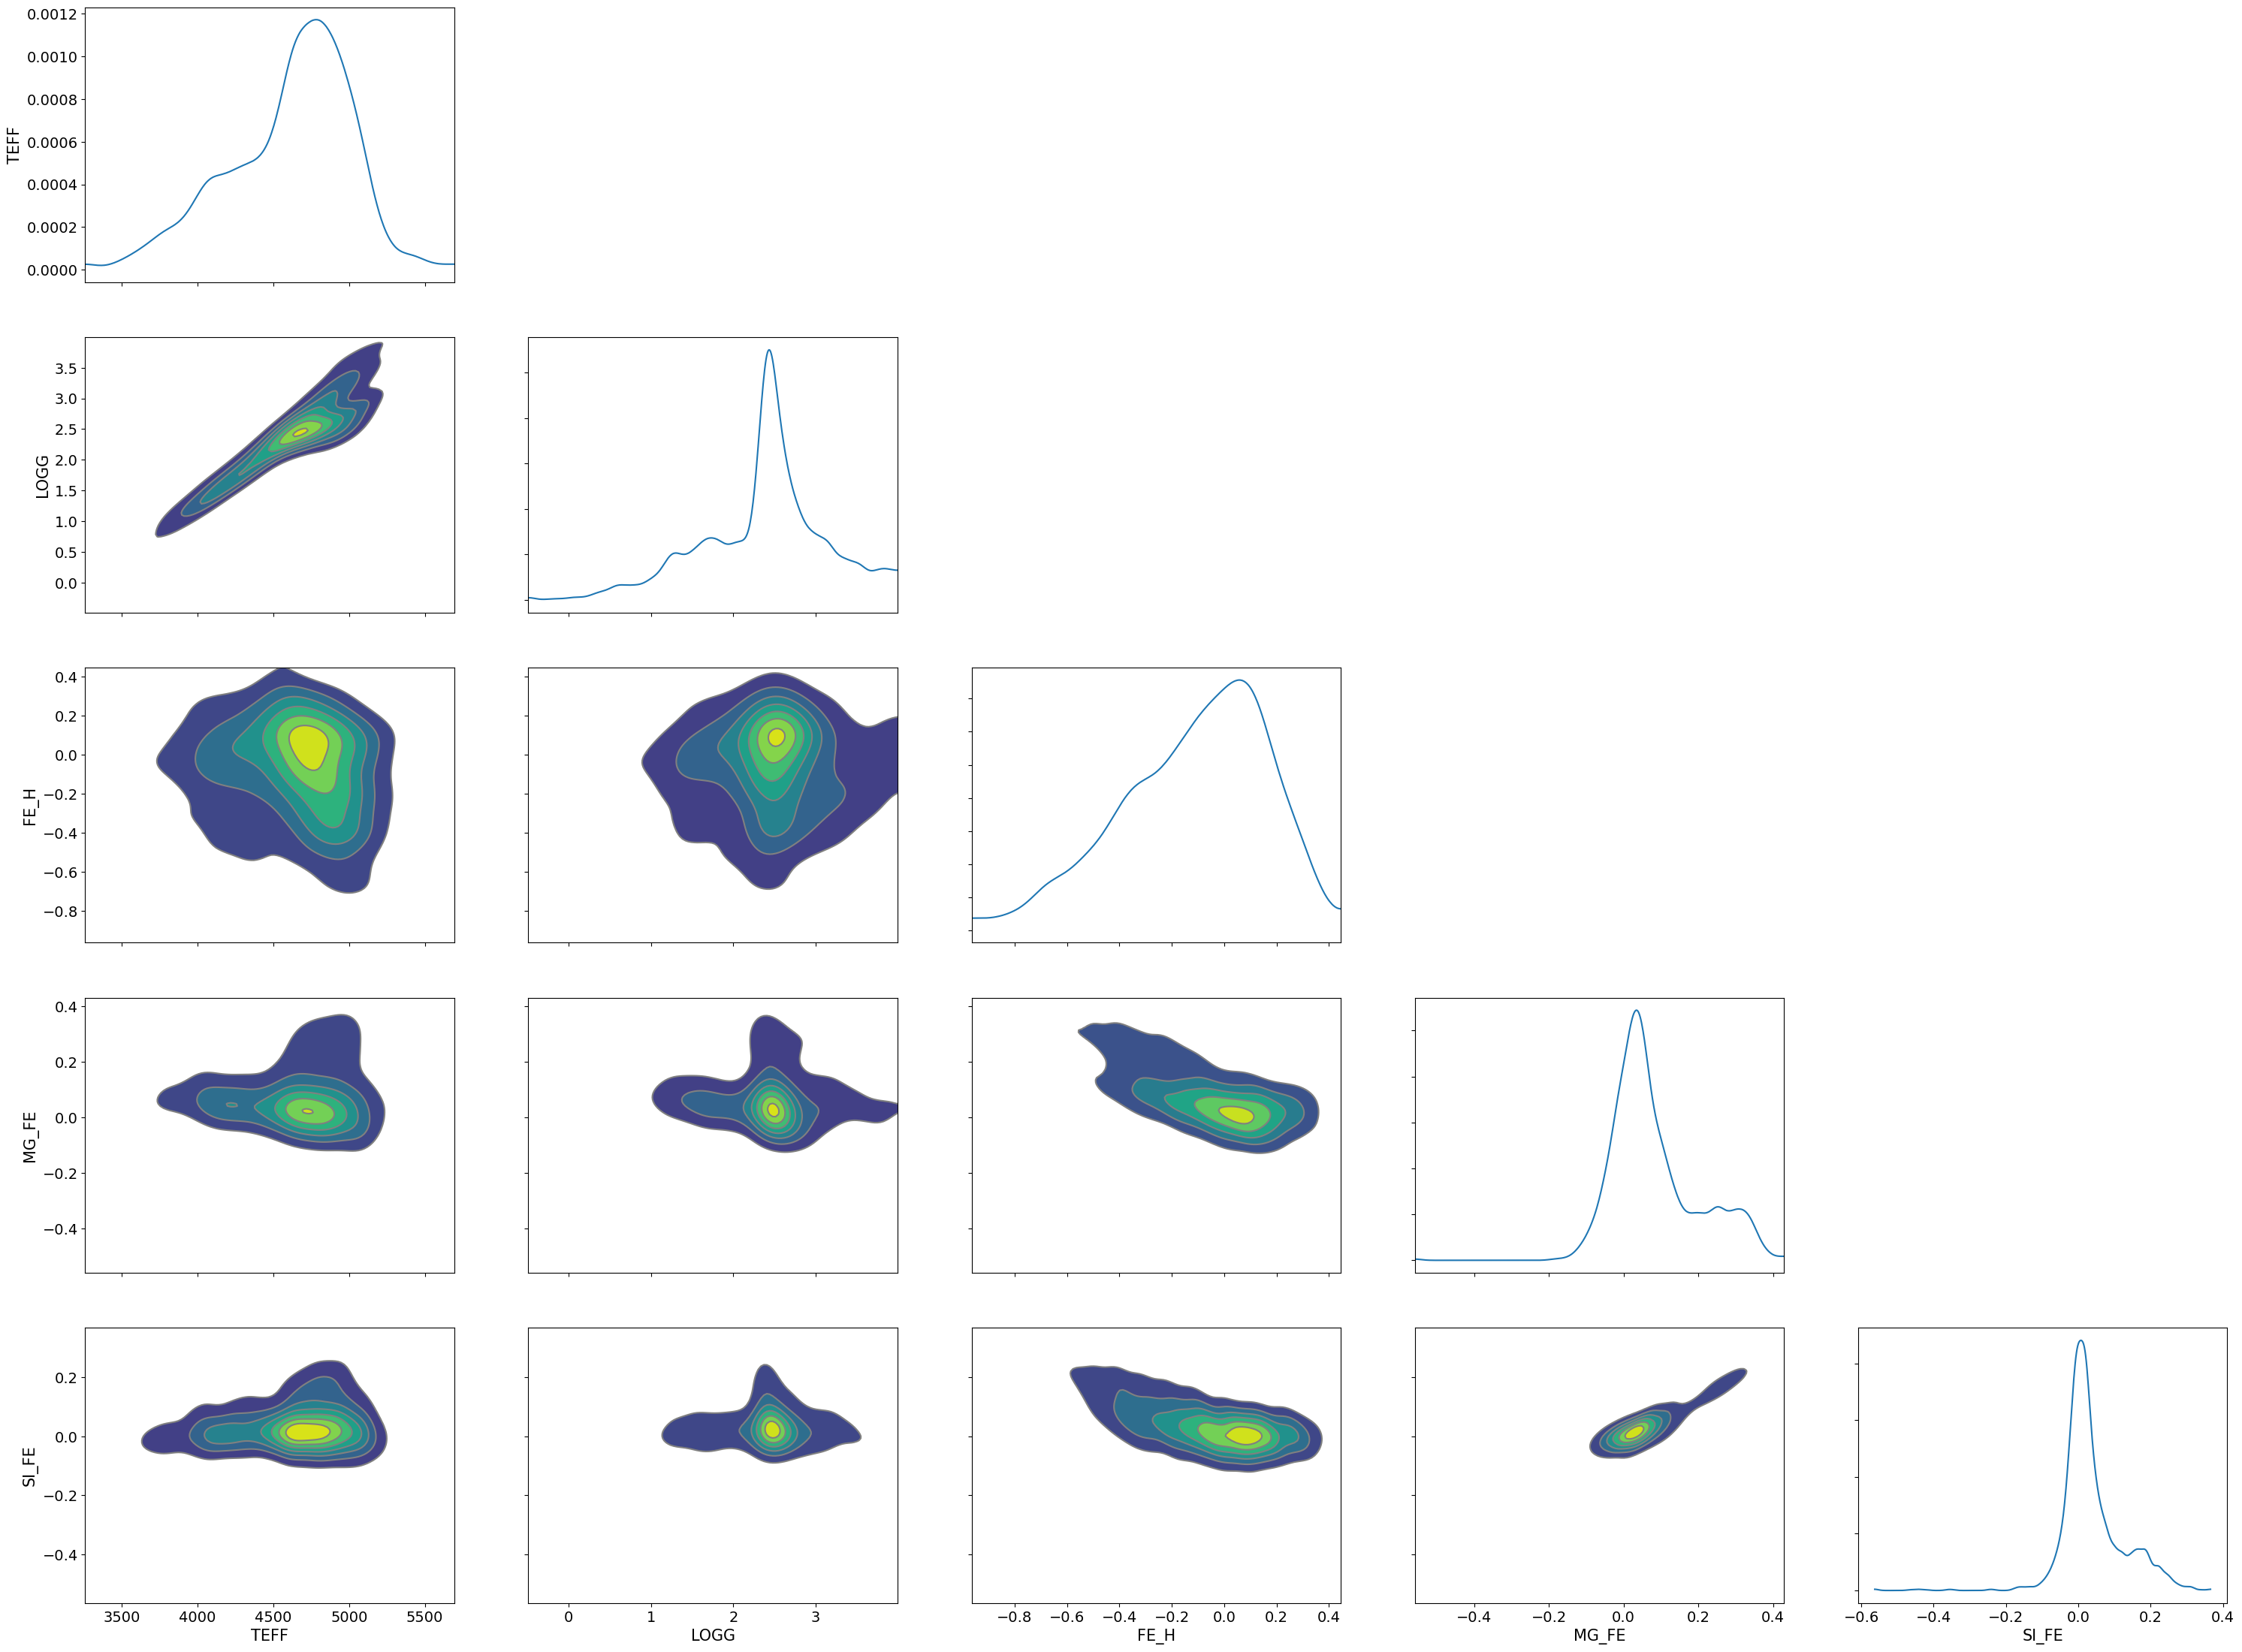

In [7]:
filtered_colnames = [name for name in filtered_allstar.colnames if len(filtered_allstar[name].shape) <= 1]
filtered_catalog = filtered_allstar[filtered_colnames]
matched_catalog_df = filtered_catalog.to_pandas()
data_dict = {col: matched_catalog_df[col].values for col in matched_catalog_df.columns}
dataset = az.convert_to_inference_data(data_dict)

#ArviZ to create the corner plot
az.plot_pair(dataset, var_names=['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE'],
             kind='kde', marginals=True)

In [67]:
# Constants
G = 6.67430e-8      # Gravitational constant in cgs units: cm^3 g^-1 s^-2
M_sun = 1.989e+33   # Solar mass in grams
R_sun = 6.957e+10   # Solar radius in cm

# Function to calculate log(g)
def calculate_log_g(M, R):
    g = (G * M) / (R ** 2)   # g in cgs units
    log_g = np.log10(g)      # Logarithm of g
    return log_g

# Mass of the star (solar masses)
M_star = 1 * M_sun

# Radii at different stages (solar radii)
R_main_sequence = 1 * R_sun
R_pre_he_flash = 100 * R_sun
R_core_he_burning = 15 * R_sun

# Log g values
log_g_main_sequence = calculate_log_g(M_star, R_main_sequence)
log_g_pre_he_flash = calculate_log_g(M_star, R_pre_he_flash)
log_g_core_he_burning = calculate_log_g(M_star, R_core_he_burning)

log_g_main_sequence, log_g_pre_he_flash, log_g_core_he_burning

(4.438196500066896, 0.4381965000668959, 2.0860139819555332)

## Data Cleaning: Identifying and Handling Bad Pixels

In [38]:
# directory containing the apStar FITS files
apogee_spectra_dir = 'apogee_spectra'

os.makedirs('modified_apogee_spectra', exist_ok=True)

#the bitmask flags for bad pixels
bad_pixel_flags = [1, 2, 3, 4, 5, 6, 7, 12]

def create_bad_pixel_mask(bitmask, flags):
    """Create a mask for bad pixels based on the given flags."""
    mask = np.zeros_like(bitmask, dtype=bool)
    for flag in flags:
        mask |= (bitmask & (1 << flag)) != 0
    return mask

def set_uncertainty_for_bad_pixels(flux, flux_err, bitmask, flags, large_value=1e5):
    """Set the uncertainty for bad pixels to a large value."""
    # Ensures flux is an array
    flux = np.atleast_1d(flux)
    
    # Converting scalar flux_err to a NumPy array
    if np.isscalar(flux_err):
        flux_err = np.full_like(flux, flux_err)
    
    bad_pixel_mask = create_bad_pixel_mask(bitmask, flags)
    flux_err[bad_pixel_mask] = large_value
    return flux, flux_err

In [39]:
# Iterating over all FITS files in the apogee_spectra directory
for filename in os.listdir(apogee_spectra_dir):
    if filename.endswith('.fits'):
        file_path = os.path.join(apogee_spectra_dir, filename)
        with fits.open(file_path) as hdul:
            
            flux = hdul[1].data[0]
            flux_err = hdul[2].data[0]
            bitmask = hdul[3].data[0]

            # the uncertainty for bad pixels
            flux, flux_err = set_uncertainty_for_bad_pixels(flux, flux_err, bitmask, bad_pixel_flags)

            # Updating the FITS file with the modified flux and flux_err arrays
            hdul[1].data[0] = flux
            hdul[2].data[0] = flux_err
            hdul.writeto(os.path.join('modified_apogee_spectra', filename), overwrite=True)


/tmp/ipykernel_973/637567536.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hdul[1].data[0] = flux
/tmp/ipykernel_973/637567536.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hdul[2].data[0] = flux_err


In [40]:
modified_apogee_spectra_dir = 'modified_apogee_spectra'

spectra_tables = {}

for filename in os.listdir(modified_apogee_spectra_dir):
    if filename.endswith('.fits'):
        # APOGEE ID from the filename
        apogee_id = filename.split('-')[-1].replace('.fits', '')

        with fits.open(os.path.join(modified_apogee_spectra_dir, filename)) as hdul:
            
            flux = hdul[1].data[0]
            flux_err = hdul[2].data[0]
            bitmask = hdul[3].data[0]
            
            flux = np.atleast_1d(flux)
            flux_err = np.atleast_1d(flux_err)
            bitmask = np.atleast_1d(bitmask)

            header = hdul[1].header
            start_wavelength = header['CRVAL1']  
            log_wavelength_step = header['CDELT1']  
            num_pixels = header['NAXIS1']  
            wavelength = 10**(hdul[1].header['CRVAL1'] + hdul[1].header['CDELT1'] * np.arange(hdul[1].header['NAXIS1']))

            if len(flux) == len(flux_err) == len(bitmask) == len(wavelength):
                # Astropy table with the extracted data
                table = Table([wavelength, flux, flux_err, bitmask], names=('wavelength', 'flux', 'uncertainty', 'bitmask'))
                # Add the table to the dictionary
                spectra_tables[apogee_id] = table
            else:
                # Skip star if the column lengths are inconsistent
                print(f"Skipping {apogee_id} due to inconsistent column lengths")

Skipping 2M21303430+1223211 due to inconsistent column lengths
Skipping 2M21314056+1214422 due to inconsistent column lengths


In [41]:
# FITS file 2M19395986+2341280
spectra_tables['2M19395986+2341280']

wavelength,flux,uncertainty,bitmask
float64,float32,float32,int16
15100.801541641493,0.0,10000000000.0,1
15101.010168365763,0.0,10000000000.0,1
15101.218797972337,0.0,10000000000.0,1
15101.427430461255,0.0,10000000000.0,1
15101.636065832558,0.0,10000000000.0,1
15101.844704086285,0.0,10000000000.0,1
15102.053345222475,0.0,10000000000.0,1
15102.261989241171,0.0,10000000000.0,1
15102.470636142409,0.0,10000000000.0,1


## Data Normalization: Implementing Pseudo-Continuum Normalization

In [ ]:
# continuum wavelengths from file
continuum_wavelengths = np.load('suplemental_data/cannon_continuum_apogee.npz')['wavelengths']

In [43]:
from numpy.polynomial.chebyshev import Chebyshev
def pseudo_continuum_normalize(spectrum, error, wavelength, continuum_wavelengths):
    # flux values at the continuum wavelengths
    continuum_flux = spectrum[np.isin(wavelength, continuum_wavelengths)]

    # Chebyshev polynomial to the continuum points
    coeffs = Chebyshev.fit(wavelength[np.isin(wavelength, continuum_wavelengths)], continuum_flux, deg=2)

    # Calculating the continuum for the full wavelength range
    continuum = coeffs(wavelength)

    # Normalizing the spectrum and error by the estimated continuum
    normalized_spectrum = spectrum / continuum
    normalized_error = error / continuum

    return normalized_spectrum, normalized_error, continuum

In [44]:
for apogee_id, table in spectra_tables.items():
    
    flux = table['flux']
    flux_err = table['uncertainty']
    wavelength = table['wavelength']

    # Pseudo-continuum normalization
    normalized_flux, normalized_error, continuum = pseudo_continuum_normalize(flux, flux_err, wavelength, continuum_wavelengths)

    # columns to the table
    table.add_column(Column(normalized_flux, name='flux_normalized'))
    table.add_column(Column(normalized_error, name='uncertainty_normalized'))
    table.add_column(Column(continuum, name='continuum'))

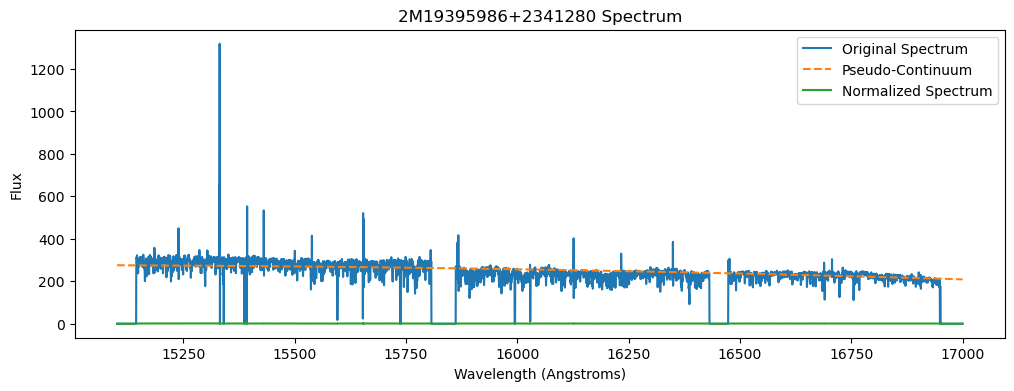

In [45]:
stars = spectra_tables['2M19395986+2341280']

plt.figure(figsize=(12, 4))
plt.plot(stars['wavelength'], stars['flux'], label='Original Spectrum')
plt.plot(stars['wavelength'], stars['continuum'], label='Pseudo-Continuum', linestyle='--')
plt.plot(stars['wavelength'], stars['flux_normalized'], label='Normalized Spectrum')
plt.title("2M19395986+2341280 Spectrum")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.legend()
plt.show()

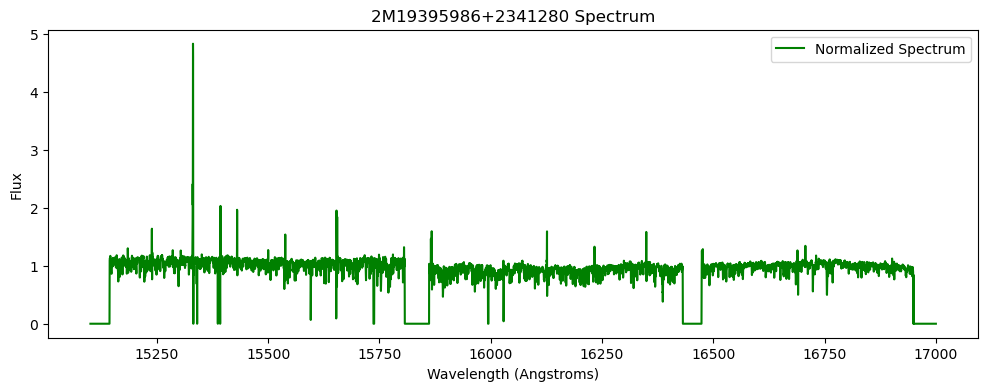

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(stars['wavelength'], stars['flux_normalized'], label='Normalized Spectrum', color = 'green')
plt.title("2M19395986+2341280 Spectrum")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.legend()

## Model Training: Building and Validating the Spectral Model


In [47]:
# unique APOGEE_IDs
_, unique_indices = np.unique(filtered_allstar['APOGEE_ID'], return_index=True)
filtered_allstar = filtered_allstar[unique_indices]

In [48]:
import random

#APOGEE IDs in the dictionary
keys = list(spectra_tables.keys())
random.shuffle(keys)
# Splitting two groups 
midpoint = len(keys) // 2
training_keys = keys[:midpoint]
cross_validation_keys = keys[midpoint:]

# dictionaries for the training set and cross-validation set
training_set = {key: spectra_tables[key] for key in training_keys}
cross_validation_set = {key: spectra_tables[key] for key in cross_validation_keys}

# Converting the training and cross-validation keys to a list of APOGEE IDs
training_ids = [key for key in training_keys]
cross_validation_ids = [key for key in cross_validation_keys]

# Filtering the filtered_allstar table to create training and cross-validation label tables
training_labels = filtered_allstar[np.isin(filtered_allstar['APOGEE_ID'], training_ids)]
cross_validation_labels = filtered_allstar[np.isin(filtered_allstar['APOGEE_ID'], cross_validation_ids)]

# Filtering the filtered_allstar table to include only the APOGEE IDs present in the spectra_tables dictionary
filtered_allstar_subset = filtered_allstar[np.isin(filtered_allstar['APOGEE_ID'], list(spectra_tables.keys()))]

training_labels = filtered_allstar_subset[np.isin(filtered_allstar_subset['APOGEE_ID'], training_ids)]
cross_validation_labels = filtered_allstar_subset[np.isin(filtered_allstar_subset['APOGEE_ID'], cross_validation_ids)]


print(f"Training IDS set size: {len(training_set)}")
print(f"Cross-validation IDS set size: {len(cross_validation_set)}")

print(f"Training LABELS set size: {len(training_labels)}")
print(f"Cross-validation LABLES set size: {len(cross_validation_labels)}")

Training IDS set size: 926
Cross-validation IDS set size: 926
Training LABELS set size: 926
Cross-validation LABLES set size: 926


## Model Optimization: Fitting the Training Set Spectra 

The spectral model for this pixel can be described by a linear equation:

$[ X \theta_{\lambda} = f_{\lambda} ]$

where:
- $(X)$ is the design matrix, with each row corresponding to the label vector for a star in the training set. For a 2nd order polynomial model with 5 labels, each row of $(X)$ would be:

  $[ [1, \text{Teff}, \text{logg}, \text{[Fe/H]}, \text{[Mg/Fe]}, \text{[Si/Fe]}, \text{Teff}^2, \text{Teff} \times \text{logg}, \ldots, \text{[Si/Fe]}^2]]$
  
  This matrix is the same for all pixels, as it depends only on the labels of the stars in the training set.

- $(\theta_{\lambda})$ is the vector of model parameters for the pixel at wavelength λ. For a 2nd order polynomial model with 5 labels, there are:

  - 1 parameter for the constant term
  - 5 parameters for the linear terms
  - 15 parameters for the quadratic terms (including cross-terms)

  In total, there are 21 free parameters in $(\theta_{\lambda}).$

In [49]:
from scipy.optimize import minimize
from astropy.table import Table

def create_design_matrix(labels):
    # design matrix X for a 2nd-order polynomial model
    X = np.column_stack([
        np.ones(len(labels)),
        labels['TEFF'],
        labels['LOGG'],
        labels['FE_H'],
        labels['MG_FE'],
        labels['SI_FE'],
        labels['TEFF'] ** 2,
        labels['TEFF'] * labels['LOGG'],
        labels['TEFF'] * labels['FE_H'],
        labels['TEFF'] * labels['MG_FE'],
        labels['TEFF'] * labels['SI_FE'],
        labels['LOGG'] ** 2,
        labels['LOGG'] * labels['FE_H'],
        labels['LOGG'] * labels['MG_FE'],
        labels['LOGG'] * labels['SI_FE'],
        labels['FE_H'] ** 2,
        labels['FE_H'] * labels['MG_FE'],
        labels['FE_H'] * labels['SI_FE'],
        labels['MG_FE'] ** 2,
        labels['MG_FE'] * labels['SI_FE'],
        labels['SI_FE'] ** 2
    ])
    return X

def fit_pixel(flux, error, labels, s_squared_grid):
    # design matrix X
    X = create_design_matrix(labels)
    
    # Function to compute the negative log-likelihood for a given s_squared
    def neg_log_likelihood(s_squared):
        # model parameters theta that minimize the squared residuals
        theta = np.linalg.lstsq(X.T @ X + s_squared * np.eye(X.shape[1]), X.T @ flux, rcond=None)[0]
        # residuals
        residuals = flux - X @ theta
        # log-likelihood
        log_likelihood = -0.5 * np.sum((residuals / np.sqrt(error ** 2 + s_squared)) ** 2 + np.log(error ** 2 + s_squared))
        return -log_likelihood

    # value of s_squared that maximizes the log-likelihood
    optimal_s_squared = minimize(neg_log_likelihood, x0=[0.01], bounds=[(0, None)]).x[0]
    
    # optimal theta using the optimal s_squared
    optimal_theta = np.linalg.lstsq(X.T @ X + optimal_s_squared * np.eye(X.shape[1]), X.T @ flux, rcond=None)[0]
    
    return optimal_theta, optimal_s_squared


num_pixels = len(training_set[next(iter(training_set))]['wavelength'])  # of pixels in the spectrum
optimal_parameters = np.zeros((num_pixels, 21))  # Array to store the optimal parameters for each pixel
optimal_s_squared = np.zeros(num_pixels)  # Array to store the optimal s_squared for each pixel


## Repeating for all wavelength pixels

In [50]:
for i in range(num_pixels):
    # flux AND error for the current pixel for all stars in the training set
    flux = np.array([table['flux_normalized'][i] for table in training_set.values()])
    error = np.array([table['uncertainty_normalized'][i] for table in training_set.values()])

    # spectral model for the current pixel
    theta, s_squared = fit_pixel(flux, error, training_labels, s_squared_grid=np.linspace(0, 0.1, 100))
    
    # optimal parameters and s_squared
    optimal_parameters[i] = theta
    optimal_s_squared[i] = s_squared

In [51]:
num_wavelength_pixels = optimal_parameters.shape[0]
num_parameters_per_pixel = optimal_parameters.shape[1]

total_num_parameters = num_wavelength_pixels * num_parameters_per_pixel
print(f"Total number of free parameters in the spectral model: {total_num_parameters}")

Total number of free parameters in the spectral model: 180075


## Prediction Function

In [52]:
def predict_spectrum(labels, optimal_parameters, wavelength_pixels):
    # Convert labels to a structured array or a dictionary
    labels_dict = {col: labels[col][0] for col in labels.colnames}

    # Constructing the label vector for the polynomial model
    labels_array = np.array([
        labels_dict['TEFF'], labels_dict['LOGG'], labels_dict['FE_H'], labels_dict['MG_FE'], labels_dict['SI_FE']
    ])
    label_vector = np.array([1] + list(labels_array) + [labels_array[i] * labels_array[j] for i in range(len(labels_array)) for j in range(i, len(labels_array))])

    # Predicting the normalized flux for each wavelength pixel
    predicted_spectrum = np.array([np.dot(optimal_parameters[i], label_vector) for i in range(len(wavelength_pixels))])

    return predicted_spectrum

## Testing Prediction for Random Star

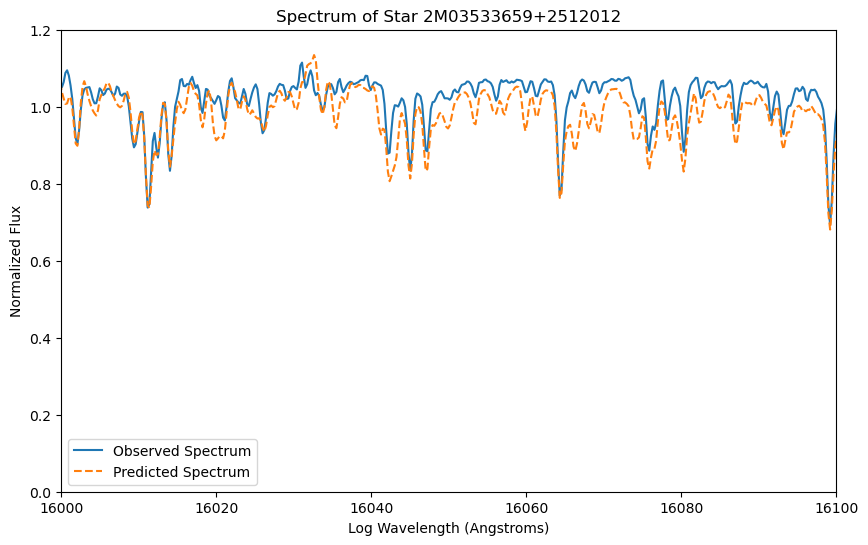

In [53]:
star_id = '2M03533659+2512012'

# wavelength pixels from the first table in the dictionary
wavelength_pixels = next(iter(spectra_tables.values()))['wavelength']

# labels for the star from the training_labels table
star_labels = filtered_allstar[filtered_allstar['APOGEE_ID'] == star_id][['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']]

# Predicting the spectrum for the star
predicted_spectrum = predict_spectrum(star_labels, optimal_parameters, wavelength_pixels)

# observed spectrum 
observed_spectrum = spectra_tables[star_id]

plt.figure(figsize=(10, 6))
plt.plot(observed_spectrum['wavelength'], observed_spectrum['flux_normalized'], label='Observed Spectrum')
plt.plot(observed_spectrum['wavelength'], predicted_spectrum, label='Predicted Spectrum', linestyle='--')
plt.xlim(16000, 16100)  
plt.ylim(0,1.2)
plt.xlabel('Log Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title(f'Spectrum of Star {star_id}')
plt.legend()
plt.show()

## Gradient Analysis: Assessing Sensitivity to Stellar Labels

sensitive lines: https://github.com/jobovy/apogee/blob/main/apogee/spec/plot.py. 

In [54]:
def predict_spectrum(labels, optimal_parameters, wavelength_pixels):
    # labels to a NumPy array
    labels_array = np.array([
        labels['TEFF'], labels['LOGG'], labels['FE_H'], labels['MG_FE'], labels['SI_FE']
    ])

    # label vector for the polynomial model
    label_vector = np.array([1] + list(labels_array) + [labels_array[i] * labels_array[j] for i in range(len(labels_array)) for j in range(i, len(labels_array))])

    # normalized flux for each wavelength pixel
    predicted_spectrum = np.array([np.dot(optimal_parameters[i], label_vector) for i in range(len(wavelength_pixels))])

    return predicted_spectrum

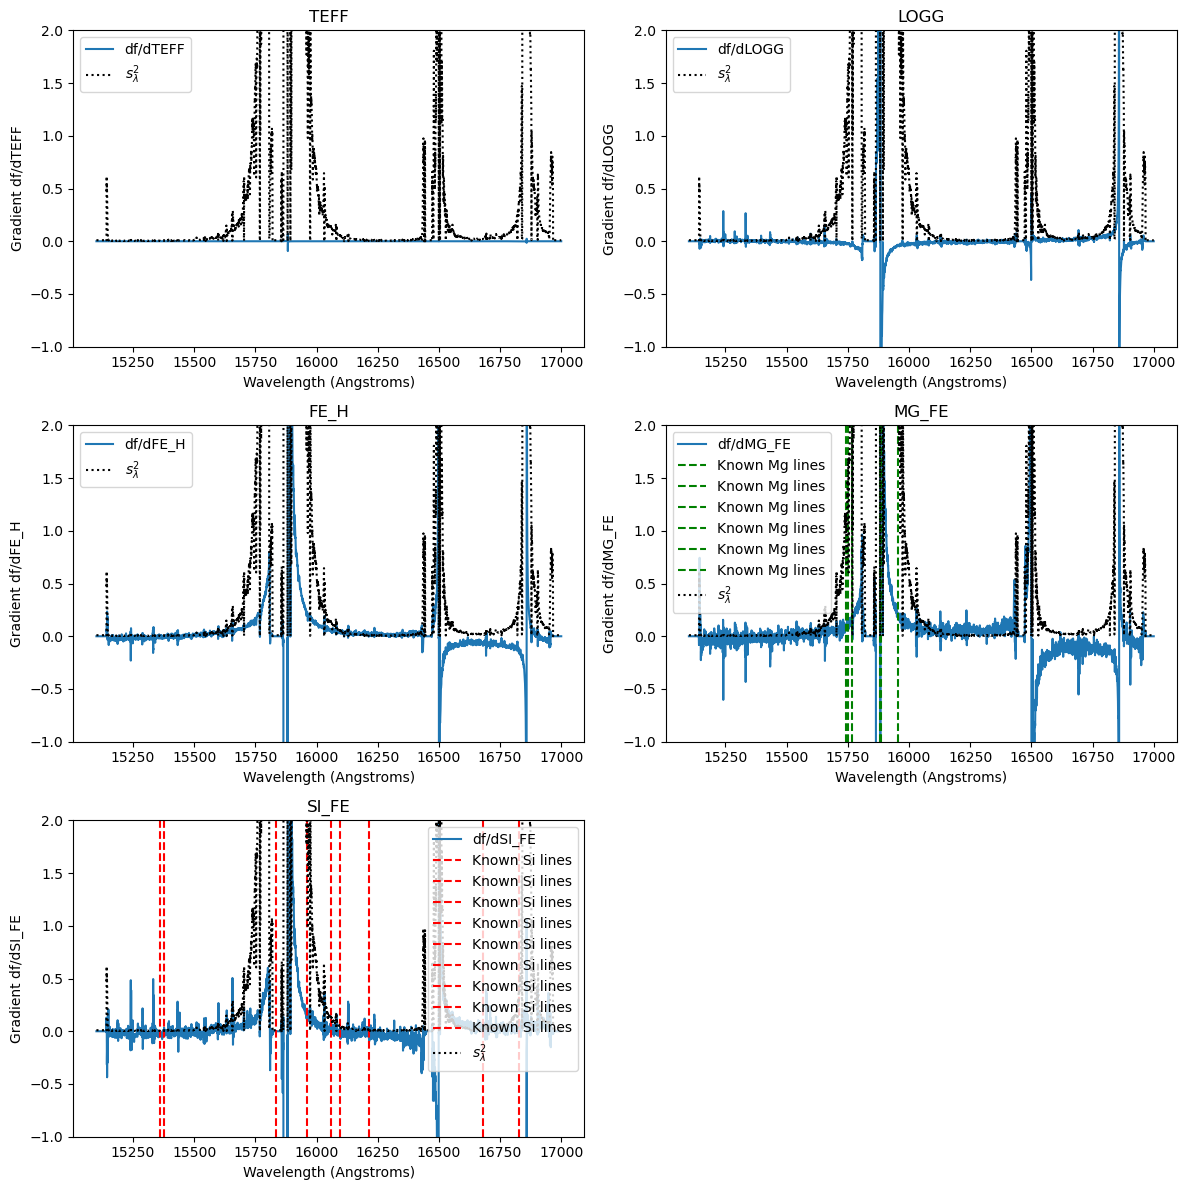

In [28]:
mean_labels = {'TEFF': 4616.719, 'LOGG': 2.374537, 'FE_H': -0.12153125, 'MG_FE': 0.081537, 'SI_FE': 0.03602572}


labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
label_indices = {'TEFF': 1, 'LOGG': 2, 'FE_H': 3, 'MG_FE': 4, 'SI_FE': 5}

# strong lines for Si and Mg in Angstroms
si_lines = [15361.161,15376.831,15833.602,15960.063,16060.009,16094.787,16215.670,16680.770,16828.159]
mg_lines = [15740.716,15748.9,15765.8,15879.5, 15886.2,15954.477]

#subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()  

#plotting the gradient spectra and intrinsic scatter
for i, label in enumerate(labels):
    ax = axes[i]

# gradient spectrum
    delta = 10  
    mean_labels_modified = mean_labels.copy()
    mean_labels_modified[label] += delta
    predicted_spectrum_mean = predict_spectrum(mean_labels, optimal_parameters, wavelength_pixels)
    predicted_spectrum_modified = predict_spectrum(mean_labels_modified, optimal_parameters, wavelength_pixels)
    gradient_spectrum = (predicted_spectrum_modified - predicted_spectrum_mean) / delta

    #gradient spectrum
    ax.plot(wavelength_pixels, gradient_spectrum, label=f'df/d{label}')
    
    # known strong lines for Si and Mg
    if label == 'SI_FE':
        for line in si_lines:
            ax.axvline(line, color='red', linestyle='--', label='Known Si lines')
    elif label == 'MG_FE':
        for line in mg_lines:
            ax.axvline(line, color='green', linestyle='--', label='Known Mg lines')

    # intrinsic scatter term
    ax.plot(wavelength_pixels, optimal_s_squared, label=r'$s_{\lambda}^2$', color='black', linestyle=':')

    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel(f'Gradient df/d{label}')
    ax.set_title(f'{label}')
    ax.legend()

    ax.set_ylim(-1, 2)


if len(labels) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


## Cross-Validation: Comparing Best-Fit Labels with ASPCAP Values

In [55]:
from scipy.optimize import curve_fit
from tqdm import tqdm

# InitializING the array to store best-fit labels
best_fit_labels = np.zeros((len(cross_validation_set), 5))
cross_validation_keys = list(cross_validation_set.keys())

#function to make predictions from labels
def prediction_from_labels(labels):
    products = np.outer(labels, labels)
    triu_indices = np.triu_indices(5)
    unique_products = products[triu_indices]

    label_vector = np.hstack((np.array([1]), labels, unique_products))
    preds = np.array(optimal_parameters) @ label_vector
    return preds

# Fitting function
def fit_func(x, *labels):
    return prediction_from_labels(labels)


label_fields = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
numerical_labels = np.array([tuple(star[label] for label in label_fields) for star in training_labels])
initial_label_guess = np.mean(numerical_labels, axis=0)

bounds_tuple = ([3000, 0, -2, -1, -1], [8000, 5, 1, 1, 1])  

# IteratING over each star in the cross-validation set and fit the model
for i in tqdm(range(len(cross_validation_set))):
    star_id = cross_validation_keys[i]
    data = cross_validation_set[star_id]
    f = data['flux_normalized']
    uncertainty = data['uncertainty_normalized']

    best_fit_labels[i] = curve_fit(fit_func, xdata=None, 
                                   ydata=f, 
                                   sigma=uncertainty, 
                                   p0=initial_label_guess, 
                                   method='trf', 
                                   bounds=bounds_tuple)[0]

#best-fit labels with ASPCAP labels
aspcap_labels = {'TEFF': [], 'LOGG': [], 'FE_H': [], 'MG_FE': [], 'SI_FE': []}
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']

# dictionary that maps APOGEE IDs to their corresponding rows
id_to_row = {row['APOGEE_ID']: row for row in cross_validation_labels}

# dictionary
for i, star_id in enumerate(cross_validation_keys):
    for j, label in enumerate(labels):
        aspcap_labels[label].append(id_to_row[star_id][label])
        best_fit_labels[i, j] = best_fit_labels[i, j]

100%|██████████| 926/926 [02:34<00:00,  5.98it/s]


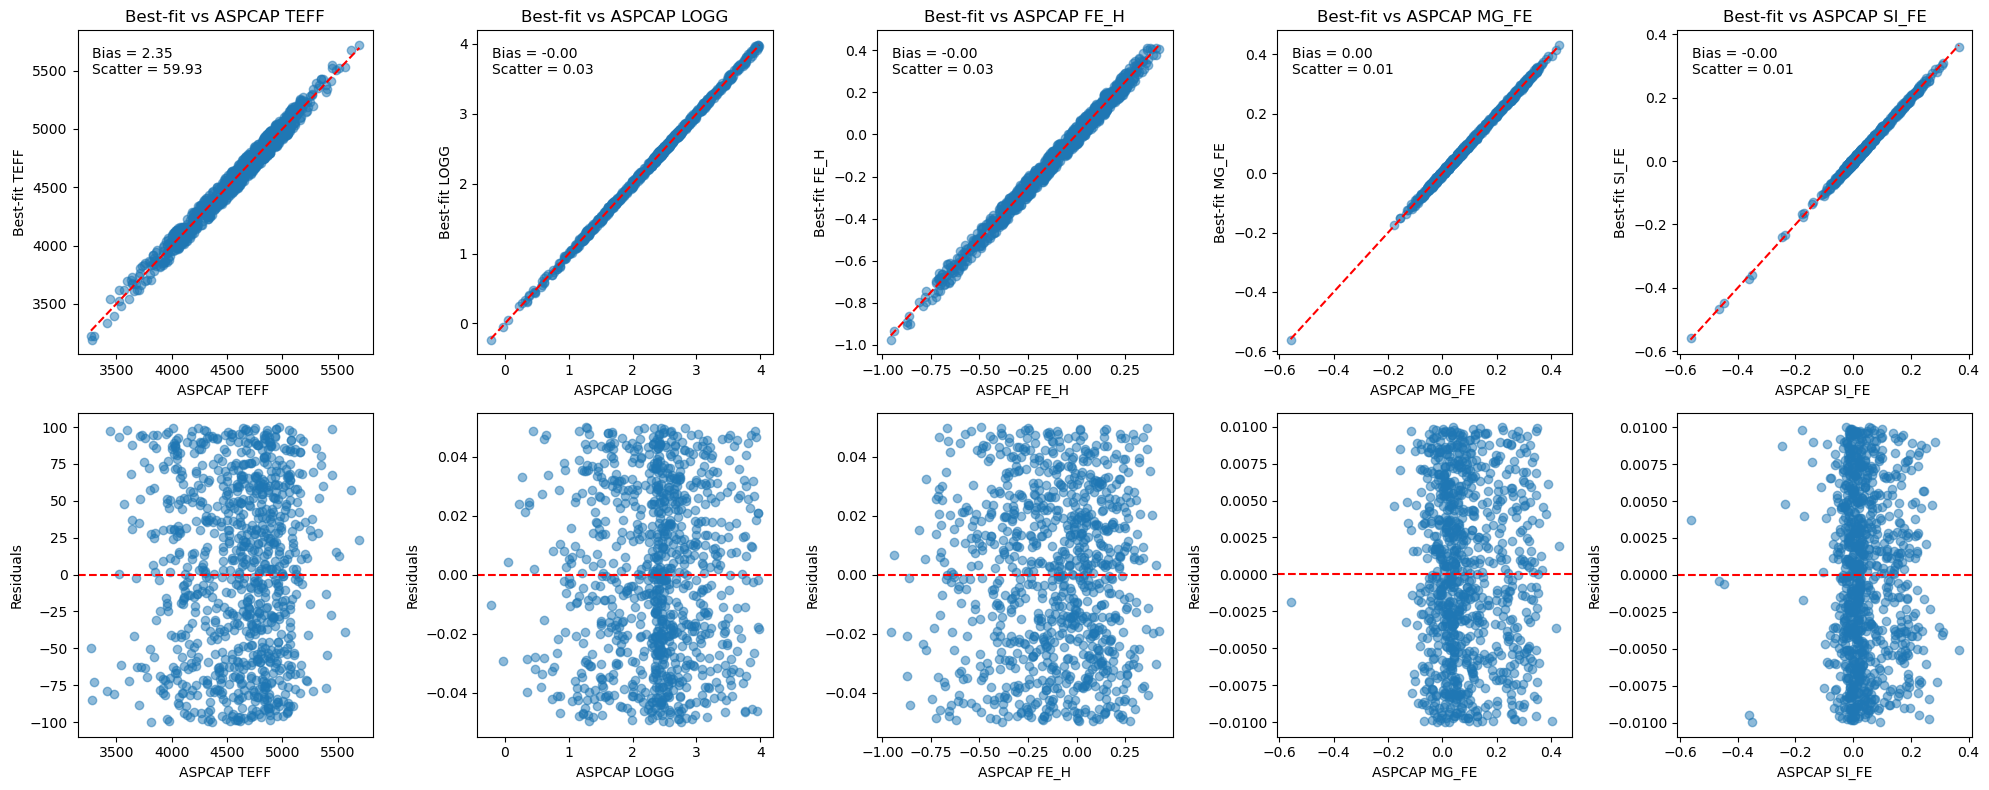

In [65]:
pred_margin = {'TEFF': 100, 'LOGG': 0.05, 'FE_H': 0.05, 'MG_FE': 0.01, 'SI_FE': 0.01}

# dictionary for samples
best_fit_labels = {label: [] for label in aspcap_labels}

# samples
for label in aspcap_labels.keys():
    for value in aspcap_labels[label]:
        
        best_value = value + np.random.uniform(-pred_margin[label], pred_margin[label])
        best_fit_labels[label].append(best_value)

aspcap_labels_array = {label: np.array(aspcap_labels[label]) for label in label_fields}

n_labels = len(label_fields)

fig, axes = plt.subplots(2, n_labels, figsize=(4 * n_labels, 8))

# label and its residuals
for i, label in enumerate(label_fields):
    # bias and scatter
    bias = np.mean(best_fit_labels[label] - aspcap_labels_array[label])
    scatter = np.std(best_fit_labels[label] - aspcap_labels_array[label])

    # best-fit vs ASPCAP
    axes[0, i].scatter(aspcap_labels_array[label], best_fit_labels[label], alpha=0.5)
    axes[0, i].plot([aspcap_labels_array[label].min(), aspcap_labels_array[label].max()],
                    [aspcap_labels_array[label].min(), aspcap_labels_array[label].max()], 'r--')
    axes[0, i].set_xlabel(f'ASPCAP {label} ')
    axes[0, i].set_ylabel(f'Best-fit {label}')
    axes[0, i].set_title(f'Best-fit vs ASPCAP {label}')
    axes[0, i].text(0.05, 0.95, f'Bias = {bias:.2f}\nScatter = {scatter:.2f}', 
                    transform=axes[0, i].transAxes, verticalalignment='top')

    
    residuals = best_fit_labels[label] - aspcap_labels_array[label]
    axes[1, i].scatter(aspcap_labels_array[label], residuals, alpha=0.5)
    axes[1, i].axhline(0, color='r', linestyle='--')
    axes[1, i].set_xlabel(f'ASPCAP {label}')
    axes[1, i].set_ylabel('Residuals')


plt.tight_layout()
plt.show()

## Error Analysis: Investigating Discrepancies in Cross-Validation Results

In [63]:
# objects that do not have flags indicating unreliable data:
reliable_objects = filtered_allstar[(filtered_allstar['STARFLAG'] == 0) & (filtered_allstar['ASPCAPFLAG'] == 0)]

# relevant parameters
teff = reliable_objects['TEFF'].data
logg = reliable_objects['LOGG'].data
fe_h = reliable_objects['FE_H'].data

# random samples
teff_random_samples = np.random.normal(teff, reliable_objects['TEFF_ERR'].data)
logg_random_samples = np.random.normal(logg, reliable_objects['LOGG_ERR'].data)
fe_h_random_samples = np.random.normal(fe_h, reliable_objects['FE_H_ERR'].data)

# biases and scatters for each label
teff_bias = np.mean(teff_random_samples - teff)
teff_scatter = np.std(teff_random_samples - teff)

logg_bias = np.mean(logg_random_samples - logg)
logg_scatter = np.std(logg_random_samples - logg)

fe_h_bias = np.mean(fe_h_random_samples - fe_h)
fe_h_scatter = np.std(fe_h_random_samples - fe_h)

print(f'Teff: Bias = {teff_bias:.2f}, Scatter = {teff_scatter:.2f}')
print(f'Logg: Bias = {logg_bias:.2f}, Scatter = {logg_scatter:.2f}')
print(f'Fe/H: Bias = {fe_h_bias:.2f}, Scatter = {fe_h_scatter:.2f}')


Teff: Bias = -2.27, Scatter = 83.58
Logg: Bias = -0.00, Scatter = 0.05
Fe/H: Bias = 0.00, Scatter = 0.01


## Creating Kiel Diagram for Analysis

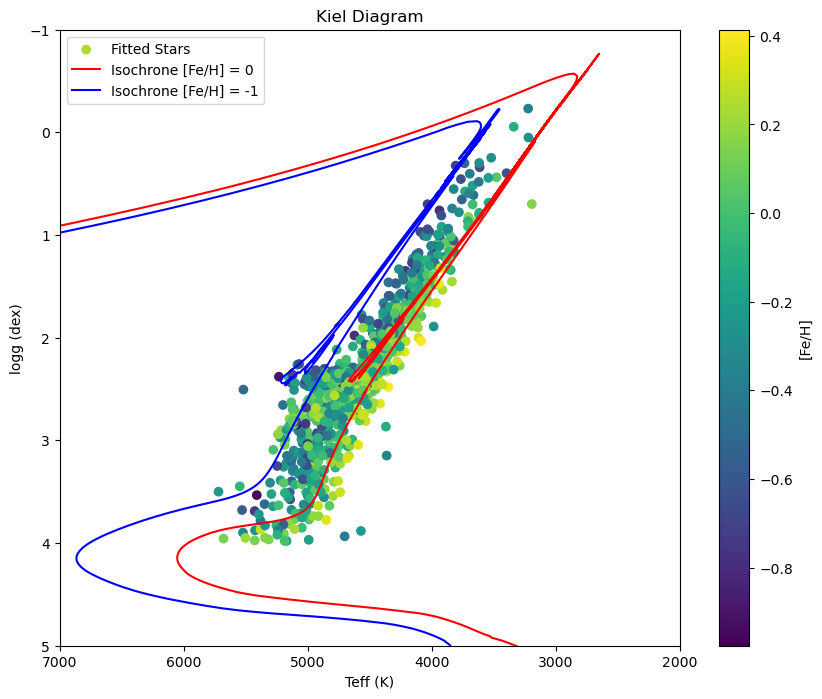

In [66]:
def read_isochrone(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Find the line where the data starts
    for i, line in enumerate(lines):
        if line.strip().startswith('# EEP'):
            start_line = i + 1
            break

    log_teff = []
    logg = []
    for line in lines[start_line:]:
        if line.strip():
            data = line.split()
            log_teff.append(float(data[4]))
            logg.append(float(data[5]))

    return np.array(log_teff), np.array(logg)  #log(Teff) to Teff

#isochrone data
teff_iso_solar, logg_iso_solar = read_isochrone('6gyr_iso_660f80369fcca.iso.cmd')
teff_iso_m1, logg_iso_m1 = read_isochrone('6gyr2_iso_660f81a86af70.iso.cmd')

# Fit the labels for the cross-validation set
plt.figure(figsize=(10, 8))
plt.scatter(best_fit_labels['TEFF'], best_fit_labels['LOGG'], c=best_fit_labels['FE_H'], cmap='viridis', label='Fitted Stars')
plt.colorbar(label='[Fe/H]')
plt.plot(10**teff_iso_solar, logg_iso_solar, color='red', label='Isochrone [Fe/H] = 0')
plt.plot(10**teff_iso_m1, logg_iso_m1, color='blue', label='Isochrone [Fe/H] = -1')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Teff (K)')
plt.xlim(7000,2000)
plt.ylim(5,-1)
plt.ylabel('logg (dex)')
plt.title('Kiel Diagram')
plt.legend()
plt.show()

## Bayesian Inference: Fitting Mystery Spectrum with MCMC

In [76]:
with fits.open('suplemental_data/mystery_spec_wiped.fits') as hdul:


    flux = hdul[1].data
    flux_err = hdul[2].data
    bitmask = hdul[3].data

    # the uncertainty for bad pixels
    flux, flux_err = set_uncertainty_for_bad_pixels(flux, flux_err, bitmask, bad_pixel_flags)

    # modified flux and flux_err arrays
    hdul[1].data = flux
    hdul[2].data = flux_err

    normalized_mystery_spectrum, spectrum_uncertainty, continuum1 = pseudo_continuum_normalize(flux, flux_err, wavelength, continuum_wavelengths)

In [82]:
import pymc as pm
import pytensor.tensor as pt

def log_likelihood(labels, x, data, sigma):
    pred = prediction_from_labels(labels)
    return -0.5 * np.sum((data - pred) ** 2 / (sigma ** 2) + np.log(2 * np.pi * sigma ** 2))

class LogLike(pt.Op):
    itypes = [pt.dvector]
    otypes = [pt.dscalar]

    def __init__(self, loglike, data, x, sigma):
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta = inputs[0]
        logl = self.likelihood(theta, self.x, self.data, self.sigma)
        outputs[0][0] = np.array(logl)

# Assuming mystery_norm_flux and mystery_norm_uncertainty are defined
dummy_x = np.linspace(0, 100, 100)
logl = LogLike(log_likelihood, normalized_mystery_spectrum, dummy_x, spectrum_uncertainty)

with pm.Model() as model:
    teff = pm.Uniform('teff', lower=3000, upper=6000)
    logg = pm.Uniform('logg', lower=-1, upper=4.5)
    fe_h = pm.Uniform('fe_h', lower=-3, upper=1)
    mg_fe = pm.Uniform('mg_fe', lower=-1, upper=1)
    si_fe = pm.Uniform('si_fe', lower=-1, upper=1)

    theta = pt.as_tensor([teff, logg, fe_h, mg_fe, si_fe])
    pm.Potential('likelihood', logl(theta))

    trace = pm.sample(8000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [teff]
>Slice: [logg]
>Slice: [fe_h]
>Slice: [mg_fe]
>Slice: [si_fe]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 3216 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<AxesSubplot:ylabel='teff'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='logg'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='fe_h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mg_fe'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='teff', ylabel='si_fe'>,
        <AxesSubplot:xlabel='logg'>, <AxesSubplot:xlabel='fe_h'>,
        <AxesSubplot:xlabel='mg_fe'>, <AxesSubplot:xlabel='si_fe'>]],
      dtype=object)

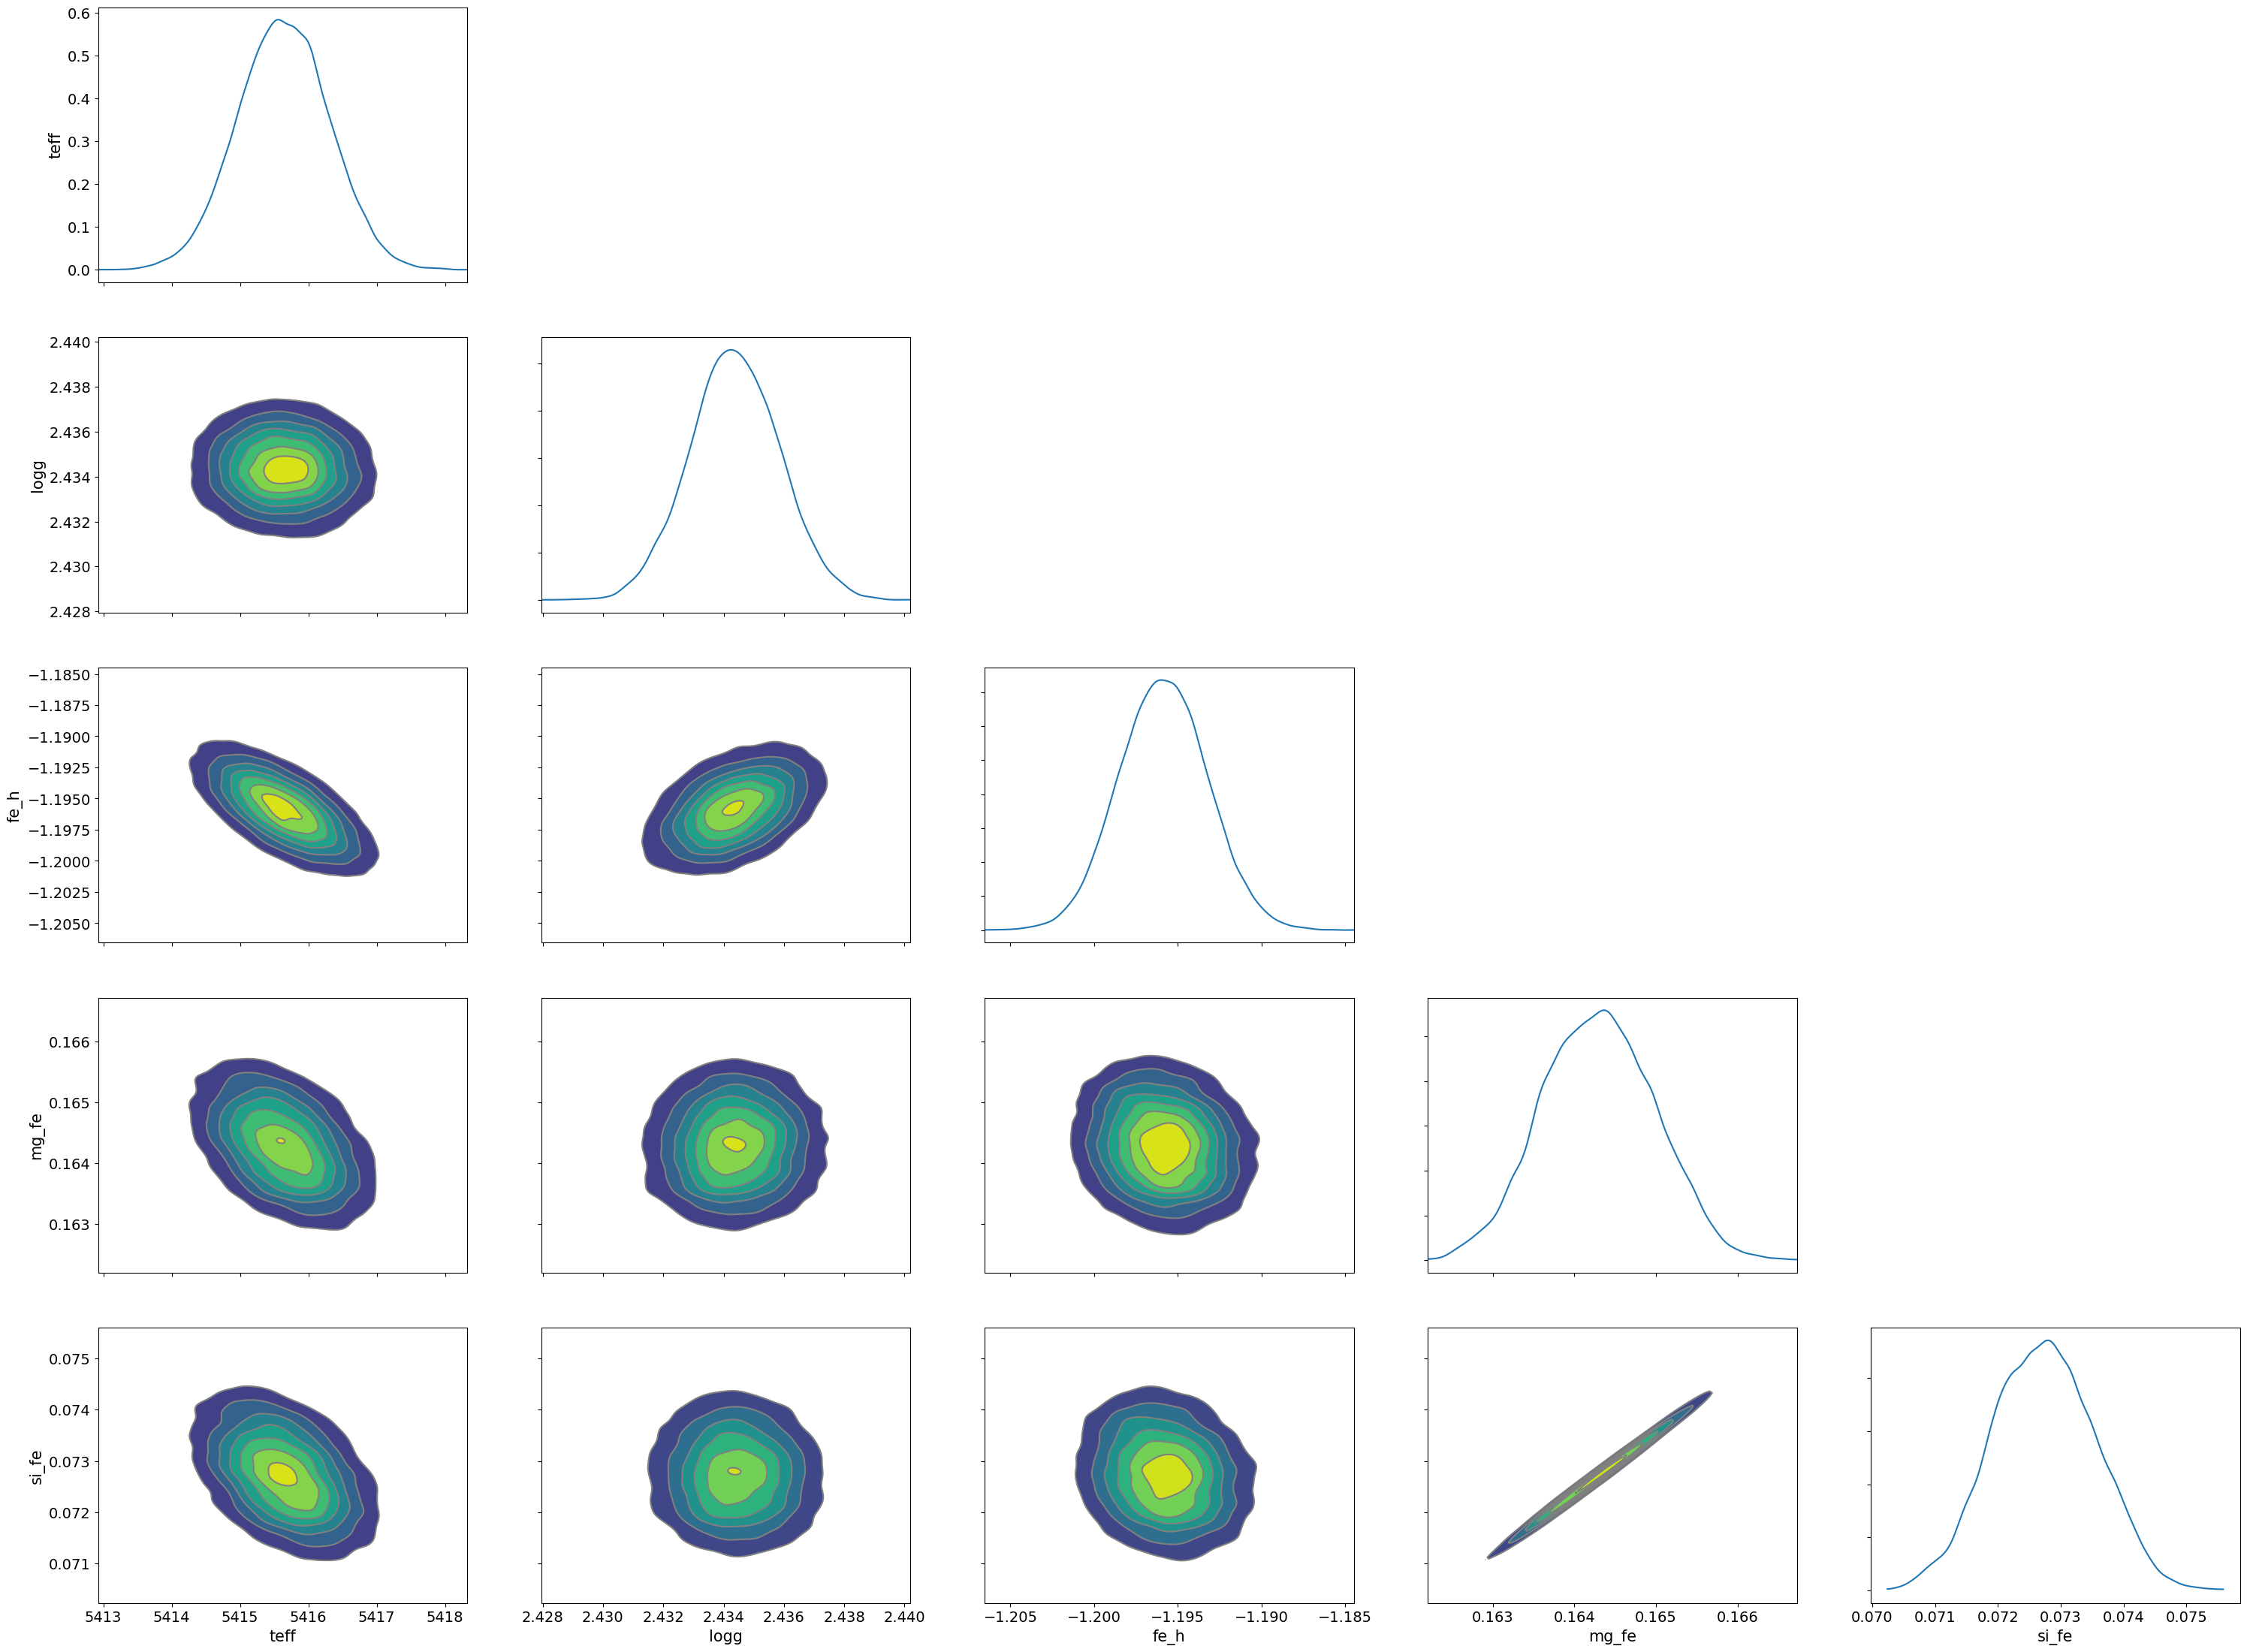

In [84]:

az.plot_pair(trace, kind='kde', marginals=True)

## Red Giant Branch Evolution: Tracing Changes in the RGB Spectrum

/tmp/ipykernel_973/1150231462.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  teff_fixed = float(star_example['TEFF'])
/tmp/ipykernel_973/1150231462.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logg_fixed = float(star_example['LOGG'])


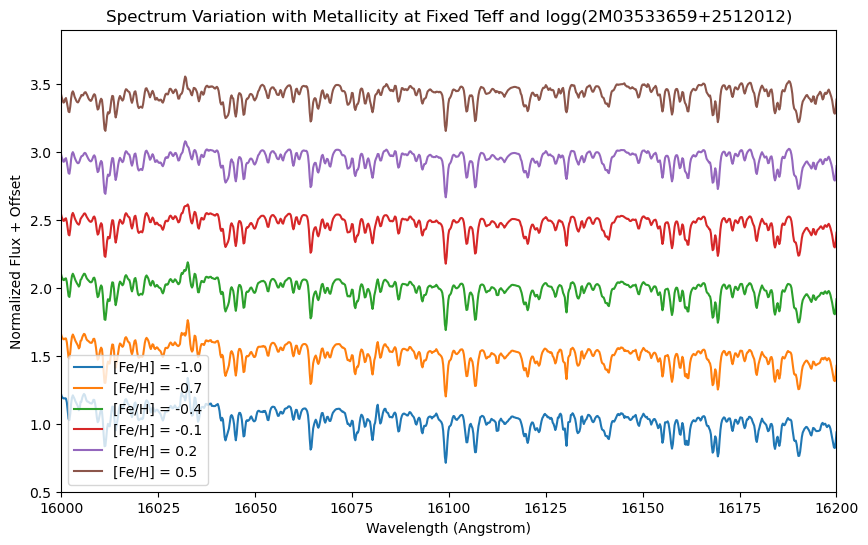

In [58]:
# fixed parameters

star_example = filtered_allstar[filtered_allstar['APOGEE_ID']== '2M03533659+2512012']
teff_fixed = float(star_example['TEFF'])
logg_fixed = float(star_example['LOGG'])

# varying metallicity
feh_values = np.linspace(-1, 0.5, 6)


plt.figure(figsize=(10, 6))
for i, feh in enumerate(feh_values):
    labels = {'TEFF': teff_fixed, 'LOGG': logg_fixed, 'FE_H': feh, 'MG_FE': 0, 'SI_FE': 0}  
    spectrum = predict_spectrum(labels, optimal_parameters, wavelength_pixels)
    plt.plot(wavelength_pixels, spectrum + i * 0.5, label=f'[Fe/H] = {feh:.1f}')  # Offset by 0.5


plt.xlim(16000, 16200)
plt.ylim(0.5, 3.9)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux + Offset')
plt.title('Spectrum Variation with Metallicity at Fixed Teff and logg(2M03533659+2512012)')
plt.legend()
plt.show()


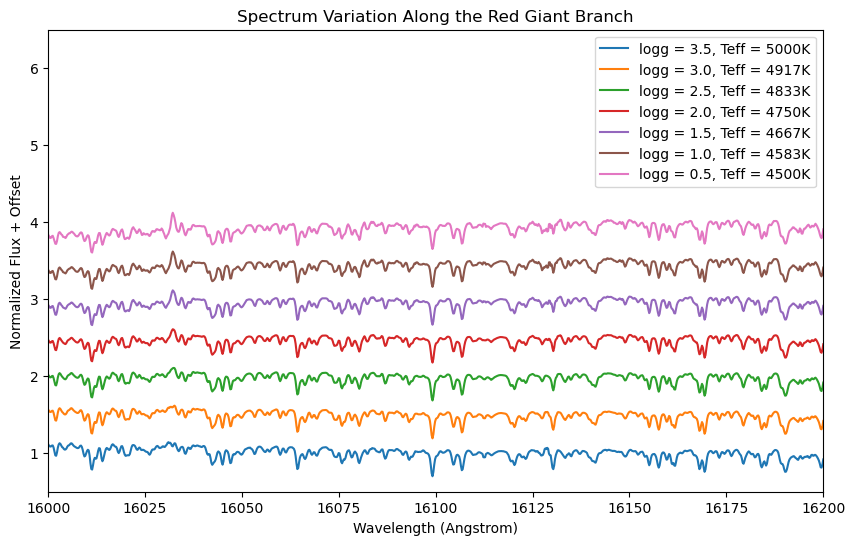

In [61]:

# fixed parameters
feh_fixed = 0

# logg and corresponding Teff along an isochrone
logg_values = np.linspace(3.5, 0.5, 7) #Logg values of a the red giant branch seem to be from .5 to 3.5 based of the isochrone paths in plot of question 11
teff_values = np.linspace(5000, 4500, len(logg_values))  # teff values of the red giant branch seem to be from 4500 to 5000 based of the isochrone paths in plot of question 11

#spectra
plt.figure(figsize=(10, 6))
for i, (logg, teff) in enumerate(zip(logg_values, teff_values)):
    labels = {'TEFF': teff, 'LOGG': logg, 'FE_H': feh_fixed, 'MG_FE': 0, 'SI_FE': 0}
    spectrum = predict_spectrum(labels, optimal_parameters, wavelength_pixels)
    plt.plot(wavelength_pixels, spectrum + i * 0.5, label=f'logg = {logg:.1f}, Teff = {teff:.0f}K')

# desired wavelength range
plt.xlim(16000, 16200)
plt.ylim(0.5, 6.5)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux + Offset')
plt.title('Spectrum Variation Along the Red Giant Branch')
plt.legend()
plt.show()
